In [3]:
!pip install transformers datasets pdf2image pytesseract torchvision Pillow
!sudo apt install tesseract-ocr  # or install Tesseract on Windows


Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets
!pip install pytesseract opencv-python
!pip install pdf2image
!pip install tabulate
!pip install Pillow


Looking in indexes: https://download.pytorch.org/whl/cu118


In [9]:
!pip install torch torchvision torchaudio
!pip install transformers datasets
!pip install pytesseract
!pip install opencv-python
!pip install layoutparser


In [11]:
!pip install torch transformers pytesseract pdf2image pillow pandas


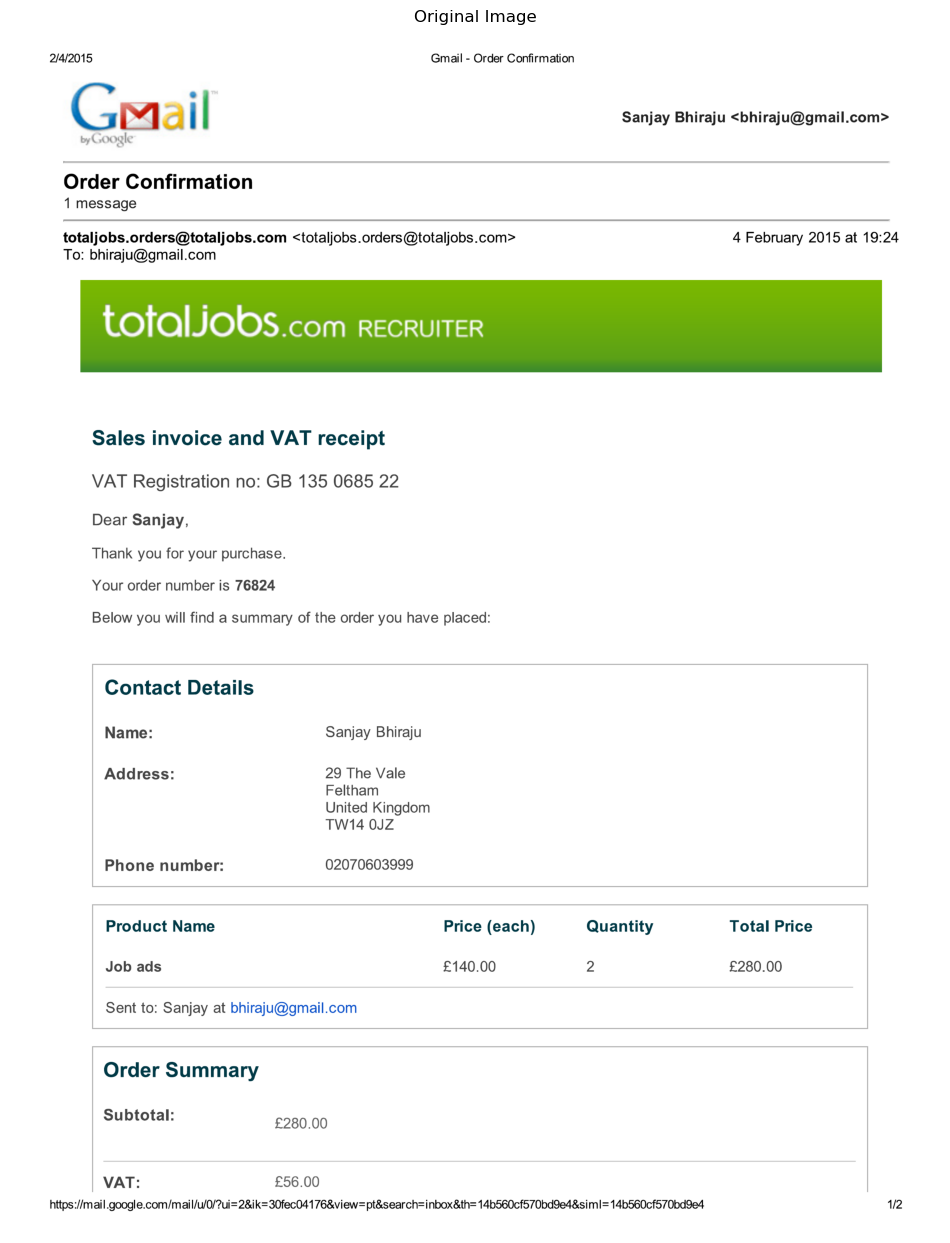

Extracting table with LayoutLMv3...


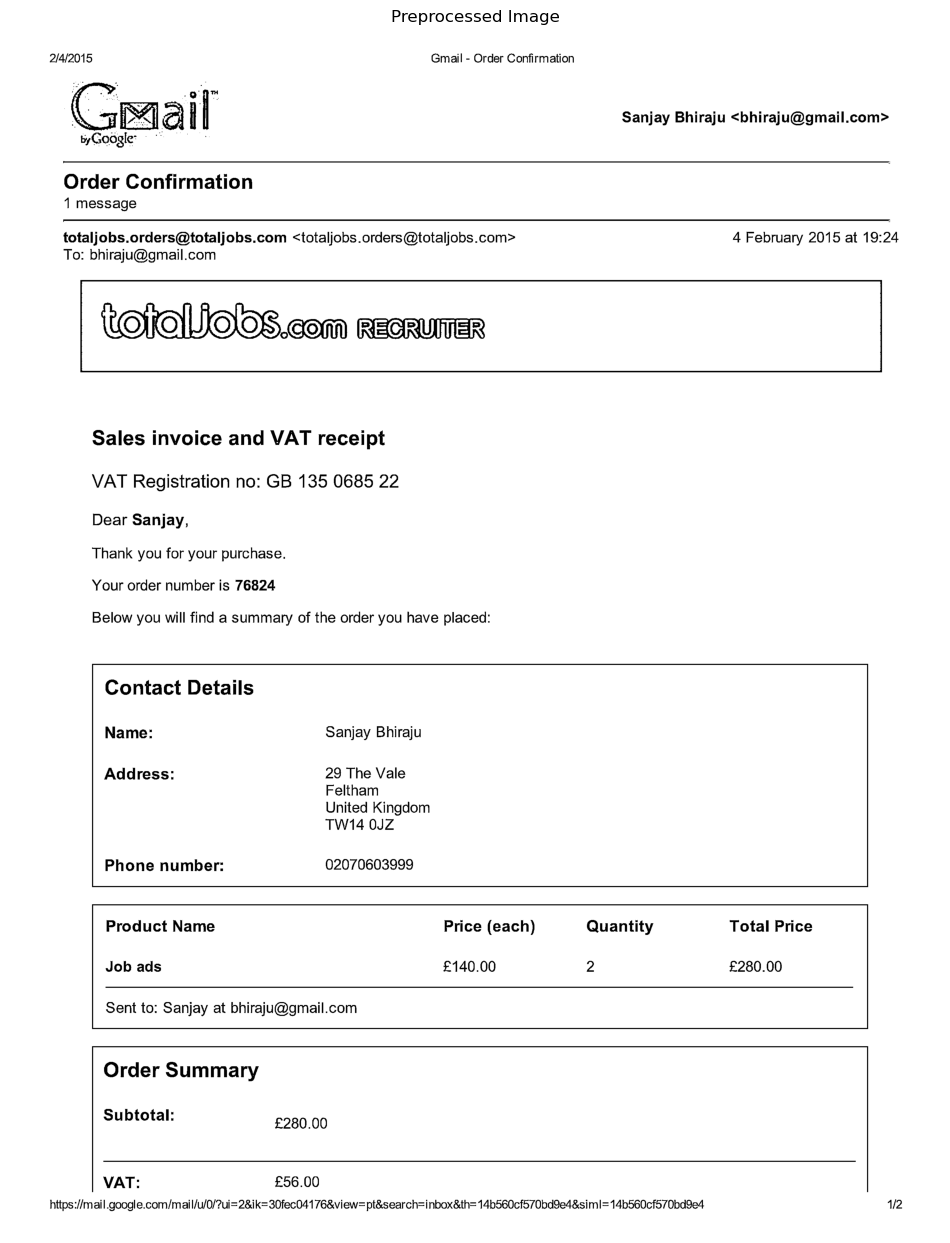

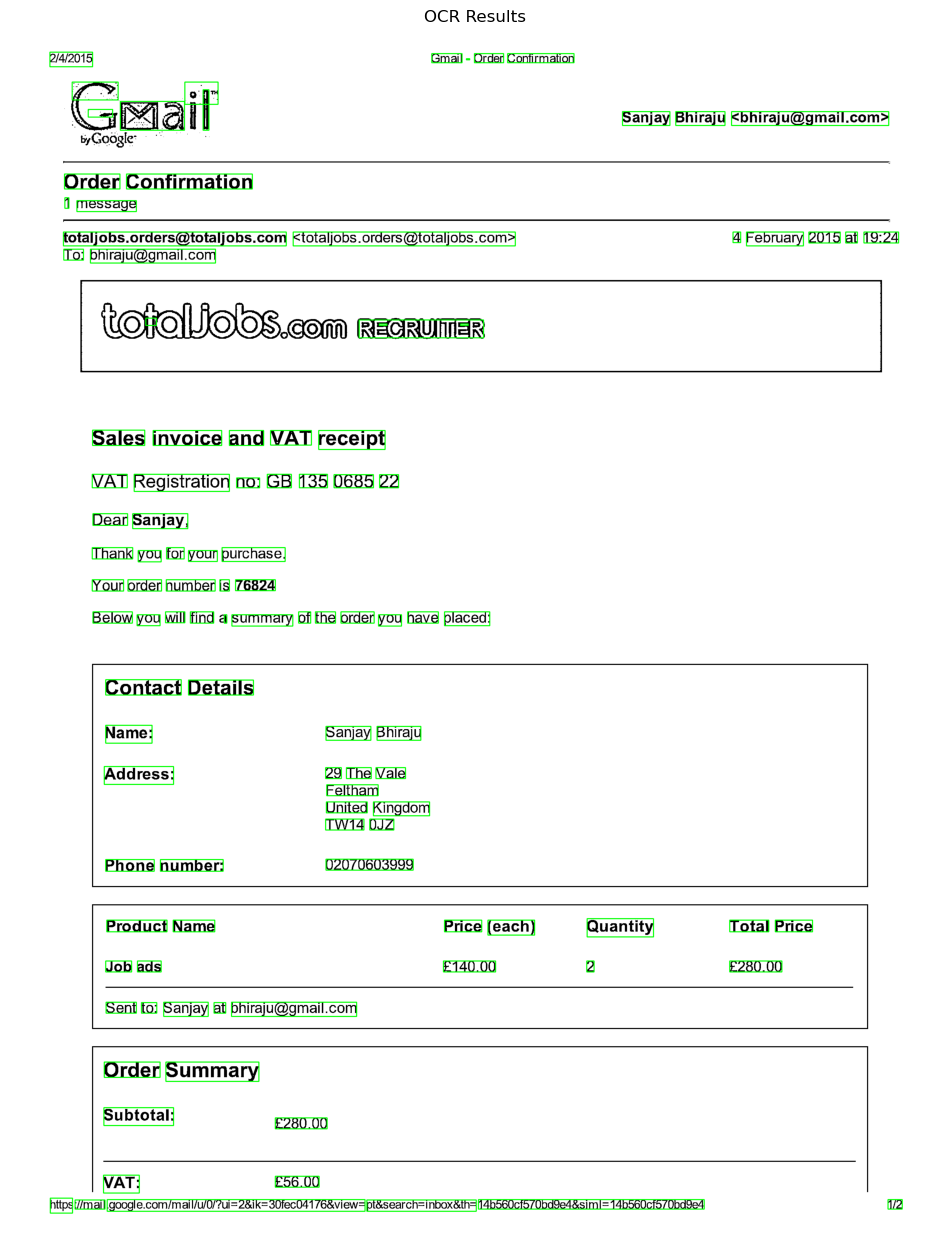

Extracted 112 words from OCR


j:\anaconda\Lib\site-packages\transformers\modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Found 5 table entities
Found 4 rows in table

Confidence Scores:
OCR Confidence: 88.52%
Model Confidence: 94.20%
Overall Confidence: 35.90%

Reconstructing table structure...

 Extracted Table:
| Contact   | Details   |                                                   |
|:----------|:----------|:--------------------------------------------------|
| Mia       |           |                                                   |
|           |           | RECRUITER RECRUITER RECRUITER RECRUITER RECRUITER |
| Sales     |           |                                                   |

 Table saved to extracted_table.csv


In [1]:
# Correct Code
import cv2
import pytesseract
from PIL import Image
import pandas as pd
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
import torch
from pdf2image import convert_from_path
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Configuration
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
pdf_path =r"C:\Users\HP\Desktop\Bank Project\Balraj\Purchase & Receipts\Total Jobs-Invoice-0402.pdf"  # Change as needed
image_path = None  #  Set to image path if using image instead of PDF
temp_folder = "temp_imgs"
os.makedirs(temp_folder, exist_ok=True)

# Load LayoutLMv3 processor and model - using a model fine-tuned for documents
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

def debug_show_image(image, title="Debug Image"):
    """Display image for debugging purposes"""
    plt.figure(figsize=(12, 16))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image):
    """Enhance image quality for better OCR results"""
    # Convert to OpenCV format
    cv_image = np.array(image)
    
    # Convert to grayscale
    gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 11, 2)
    
    # Apply morphological operations to clean the image
    kernel = np.ones((1, 1), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Convert back to RGB
    cleaned_rgb = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(cleaned_rgb)

def extract_table_with_layoutlmv3(image):
    """Extract table using LayoutLMv3 model with enhanced processing"""
    # Preprocess image
    enhanced_image = preprocess_image(image)
    image_width, image_height = enhanced_image.size
    
    # Debug: show preprocessed image
    debug_show_image(np.array(enhanced_image), "Preprocessed Image")
    
    # Perform OCR with best PSM mode for tables
    ocr_data = pytesseract.image_to_data(
        np.array(enhanced_image), 
        output_type=pytesseract.Output.DICT,
        config='--psm 6 -c preserve_interword_spaces=1'
    )
    
    # Debug: show OCR results on image
    debug_img = np.array(enhanced_image.copy())
    for i in range(len(ocr_data['text'])):
        if int(ocr_data['conf'][i]) > 0:
            x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    debug_show_image(debug_img, "OCR Results")
    
    # Prepare words, boxes, and confidences
    words, boxes, confidences = [], [], []
    for i in range(len(ocr_data['text'])):
        if int(ocr_data['conf'][i]) > 0:  # Include all words
            word = ocr_data['text'][i].strip()
            if word:
                words.append(word)
                confidences.append(int(ocr_data['conf'][i]))
                
                # Get bounding box
                left = ocr_data['left'][i]
                top = ocr_data['top'][i]
                width = ocr_data['width'][i]
                height = ocr_data['height'][i]
                right = left + width
                bottom = top + height
                
                # Normalize to 0-1000 range
                norm_left = int(1000 * (left / image_width))
                norm_top = int(1000 * (top / image_height))
                norm_right = int(1000 * (right / image_width))
                norm_bottom = int(1000 * (bottom / image_height))
                
                boxes.append([norm_left, norm_top, norm_right, norm_bottom])
    
    # Calculate OCR confidence score (average of all word confidences)
    ocr_confidence = np.mean(confidences) if confidences else 0
    
    print(f"Extracted {len(words)} words from OCR")
    
    if not words:
        return None, ocr_confidence, 0, 0
    
    # Process with LayoutLMv3
    try:
        encoding = processor(
            enhanced_image, 
            words, 
            boxes=boxes, 
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        )
        
        with torch.no_grad():
            outputs = model(**encoding)
        
        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Get token-level predictions
        input_ids = encoding.input_ids.squeeze().tolist()
        token_boxes = encoding.bbox.squeeze().tolist()
        
        # Get word IDs for all tokens in batch 0
        word_ids = encoding.word_ids(batch_index=0)
        
        # Extract entities
        entities = []
        current_entity = {"text": "", "box": None, "label": "O", "confidence": 0, "word_ids": []}
        model_confidence = 0
        token_count = 0
        
        for idx, (token_id, pred, word_idx) in enumerate(zip(input_ids, predictions, word_ids)):
            # Skip special tokens
            if token_id in [processor.tokenizer.cls_token_id, 
                           processor.tokenizer.sep_token_id, 
                           processor.tokenizer.pad_token_id]:
                continue
                
            label = model.config.id2label[pred]
            
            # Calculate model confidence for this token
            token_prob = probabilities[0, idx, pred].item()
            model_confidence += token_prob
            token_count += 1
            
            # Handle entity boundaries
            if label.startswith("B-"):
                if current_entity["text"]:
                    entities.append(current_entity)
                current_entity = {
                    "text": words[word_idx] if word_idx is not None else "",
                    "box": token_boxes[idx],
                    "label": label[2:],  # Remove B- prefix
                    "confidence": token_prob,
                    "word_ids": [word_idx] if word_idx is not None else []
                }
            elif label.startswith("I-") and current_entity["label"] == label[2:]:
                if word_idx is not None and word_idx < len(words):
                    current_entity["text"] += " " + words[word_idx]
                    current_entity["confidence"] = (current_entity["confidence"] + token_prob) / 2
                    if word_idx not in current_entity["word_ids"]:
                        current_entity["word_ids"].append(word_idx)
            else:
                if current_entity["text"]:
                    entities.append(current_entity)
                current_entity = {
                    "text": words[word_idx] if word_idx is not None else "",
                    "box": token_boxes[idx],
                    "label": "O",
                    "confidence": token_prob,
                    "word_ids": [word_idx] if word_idx is not None else []
                }
        
        if current_entity["text"]:
            entities.append(current_entity)
        
        # Filter only table-related entities
        table_entities = [e for e in entities if e["label"] in ["HEADER", "CELL"]]
        print(f"Found {len(table_entities)} table entities")
        
        # Calculate average model confidence
        model_confidence = model_confidence / token_count if token_count > 0 else 0
        
        # Group entities by rows
        rows = defaultdict(list)
        for entity in table_entities:
            y_center = (entity["box"][1] + entity["box"][3]) // 2
            rows[y_center].append(entity)
        
        # Sort rows and cells within rows
        sorted_rows = []
        for y in sorted(rows.keys()):
            # Sort cells in row by horizontal position
            row_cells = sorted(rows[y], key=lambda x: x["box"][0])
            sorted_rows.append(row_cells)
        
        print(f"Found {len(sorted_rows)} rows in table")
        
        # Calculate table structure confidence
        structure_confidence = 0
        if sorted_rows:
            # Check consistency of column counts
            col_counts = [len(row) for row in sorted_rows]
            max_cols = max(col_counts)
            min_cols = min(col_counts)
            col_consistency = (min_cols / max_cols) if max_cols > 0 else 0
            
            # Check row alignment
            row_heights = []
            for i in range(1, len(sorted_rows)):
                prev_bottom = max(cell["box"][3] for cell in sorted_rows[i-1])
                curr_top = min(cell["box"][1] for cell in sorted_rows[i])
                row_heights.append(curr_top - prev_bottom)
            
            if row_heights:
                avg_row_height = np.mean(row_heights)
                row_variance = np.std(row_heights) / avg_row_height if avg_row_height > 0 else 0
                row_alignment = 1 - min(1, row_variance)
                structure_confidence = (col_consistency + row_alignment) / 2
            else:
                structure_confidence = col_consistency
        
        # Calculate overall confidence
        overall_confidence = 0.4 * ocr_confidence + 0.4 * model_confidence + 0.2 * structure_confidence
        
        return sorted_rows, ocr_confidence, model_confidence, overall_confidence
        
    except Exception as e:
        print(f"Error processing with LayoutLMv3: {str(e)}")
        return None, ocr_confidence, 0, 0

def simple_table_extraction(image):
    """Fallback to simple OCR-based table extraction"""
    # Preprocess image
    enhanced_image = preprocess_image(image)
    
    # Use Tesseract to detect table structure
    ocr_data = pytesseract.image_to_data(
        np.array(enhanced_image), 
        output_type=pytesseract.Output.DICT,
        config='--psm 6'
    )
    
    # Group by rows
    rows = defaultdict(list)
    for i in range(len(ocr_data['text'])):
        if int(ocr_data['conf'][i]) > 60:
            word = ocr_data['text'][i].strip()
            if word:
                y_center = ocr_data['top'][i] + ocr_data['height'][i] // 2
                rows[y_center].append((ocr_data['left'][i], word))
    
    # Create sorted table
    table_data = []
    for y in sorted(rows.keys()):
        row_items = sorted(rows[y], key=lambda x: x[0])
        row_text = [word for _, word in row_items]
        table_data.append(row_text)
    
    return table_data

def reconstruct_table(row_data):
    """Reconstruct table from row data with proper formatting"""
    if not row_data:
        return None
    
    # Find column boundaries
    all_columns = []
    for row in row_data:
        for cell in row:
            center_x = (cell["box"][0] + cell["box"][2]) // 2
            all_columns.append(center_x)
    
    if not all_columns:
        return None
    
    # Cluster columns to find consistent positions
    sorted_columns = sorted(set(all_columns))
    column_groups = []
    current_group = [sorted_columns[0]]
    
    for x in sorted_columns[1:]:
        if x - current_group[-1] < 50:  # Group close columns
            current_group.append(x)
        else:
            column_groups.append(sum(current_group) / len(current_group))  # Average position
            current_group = [x]
    
    if current_group:
        column_groups.append(sum(current_group) / len(current_group))
    
    # Create table structure
    table = []
    for row in row_data:
        # Create empty row with None values
        table_row = [None] * len(column_groups)
        
        for cell in row:
            cell_center = (cell["box"][0] + cell["box"][2]) // 2
            # Find closest column
            min_dist = float('inf')
            col_idx = -1
            for i, col_pos in enumerate(column_groups):
                dist = abs(cell_center - col_pos)
                if dist < min_dist:
                    min_dist = dist
                    col_idx = i
            
            # Place in appropriate column
            if 0 <= col_idx < len(table_row):
                if table_row[col_idx] is None:
                    table_row[col_idx] = cell["text"]
                else:
                    table_row[col_idx] += " " + cell["text"]
        
        # Replace None with empty string
        table_row = [text if text is not None else "" for text in table_row]
        table.append(table_row)
    
    return table

# Main processing
if image_path:
    pil_image = Image.open(image_path).convert("RGB")
    debug_show_image(np.array(pil_image), "Original Image")
else:
    pages = convert_from_path(pdf_path, dpi=300, output_folder=temp_folder)
    pil_image = pages[0].convert("RGB")
    debug_show_image(np.array(pil_image), "Original Image")

# Extract table with LayoutLMv3
print("Extracting table with LayoutLMv3...")
row_data, ocr_confidence, model_confidence, overall_confidence = extract_table_with_layoutlmv3(pil_image)

# Display confidence scores
print("\nConfidence Scores:")
print(f"OCR Confidence: {ocr_confidence:.2f}%")
print(f"Model Confidence: {model_confidence*100:.2f}%")
print(f"Overall Confidence: {overall_confidence:.2f}%")

# Reconstruct and display table
if row_data:
    print("\nReconstructing table structure...")
    table_data = reconstruct_table(row_data)
    
    if table_data:
        # Find max columns
        max_columns = max(len(row) for row in table_data)
        
        # Pad rows to max columns
        padded_table = []
        for row in table_data:
            if len(row) < max_columns:
                row += [''] * (max_columns - len(row))
            padded_table.append(row)
        
        # Try to identify header row
        header_row = 0
        if len(padded_table) > 1:
            # Look for row with highest number of non-empty cells
            non_empty_counts = [sum(1 for cell in row if cell.strip()) for row in padded_table]
            header_row = non_empty_counts.index(max(non_empty_counts))
        
        # Create DataFrame
        try:
            headers = padded_table[header_row]
            data = [row for i, row in enumerate(padded_table) if i != header_row]
            
            # Filter empty rows
            data = [row for row in data if any(cell.strip() for cell in row)]
            
            if data:
                df = pd.DataFrame(data, columns=headers)
                print("\n Extracted Table:")
                print(df.to_markdown(index=False))
                
                # Save to CSV
                csv_path = "extracted_table.csv"
                df.to_csv(csv_path, index=False)
                print(f"\n Table saved to {csv_path}")
            else:
                print("\n Only header row detected:")
                print(pd.DataFrame([padded_table[header_row]]).to_markdown(index=False, header=False))
        except Exception as e:
            print(f"\n Error creating DataFrame: {e}")
            print("\nRaw table data:")
            for i, row in enumerate(padded_table):
                print(f"Row {i}: {row}")
    else:
        print("Table reconstruction failed")
        
        # Fallback to simple OCR extraction
        print("\n Trying simple OCR-based table extraction...")
        table_data = simple_table_extraction(pil_image)
        if table_data:
            # Create DataFrame
            max_cols = max(len(row) for row in table_data)
            padded_table = [row + [''] * (max_cols - len(row)) for row in table_data]
            
            # Try to identify header row
            header_row = 0
            if len(padded_table) > 1:
                non_empty_counts = [sum(1 for cell in row if cell.strip()) for row in padded_table]
                header_row = non_empty_counts.index(max(non_empty_counts))
            
            headers = padded_table[header_row]
            data = [row for i, row in enumerate(padded_table) if i != header_row]
            
            if data:
                df = pd.DataFrame(data, columns=headers)
                print("\n Extracted Table (Simple OCR):")
                print(df.to_markdown(index=False))
                
                # Save to CSV
                csv_path = "extracted_table_simple.csv"
                df.to_csv(csv_path, index=False)
                print(f"\n Table saved to {csv_path}")
            else:
                print("Still no table data extracted with simple method")
        else:
            print("No table data extracted with simple method")
else:
    print("No table data extracted with LayoutLMv3")
    
    # Fallback to simple OCR extraction
    print("\n Trying simple OCR-based table extraction...")
    table_data = simple_table_extraction(pil_image)
    if table_data:
        # Create DataFrame
        max_cols = max(len(row) for row in table_data)
        padded_table = [row + [''] * (max_cols - len(row)) for row in table_data]
        
        # Try to identify header row
        header_row = 0
        if len(padded_table) > 1:
            non_empty_counts = [sum(1 for cell in row if cell.strip()) for row in padded_table]
            header_row = non_empty_counts.index(max(non_empty_counts))
        
        headers = padded_table[header_row]
        data = [row for i, row in enumerate(padded_table) if i != header_row]
        
        if data:
            df = pd.DataFrame(data, columns=headers)
            print("\n Extracted Table (Simple OCR):")
            print(df.to_markdown(index=False))
            
            # Save to CSV
            csv_path = "extracted_table_simple.csv"
            df.to_csv(csv_path, index=False)
            print(f"\n Table saved to {csv_path}")
        else:
            print("Still no table data extracted with simple method")
    else:
        print("No table data extracted with simple method")

# Cleanup
if os.path.exists(temp_folder):
    # Explicitly close all images opened by convert_from_path
    if 'pages' in locals():
        for page in pages:
            try:
                page.close()
            except Exception:
                pass
    import shutil
    shutil.rmtree(temp_folder)

# # Cleanup
# if os.path.exists(temp_folder):
#     import shutil
#     shutil.rmtree(temp_folder)


In [28]:
!pip install transformers accelerate torchvision torchaudio
!pip install -U huggingface_hub


   ---------------------------------------- 0.0/558.8 kB ? eta -:--:--
   ------------------------------------- -- 524.3/558.8 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 558.8/558.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4


In [2]:
import os
import cv2
import pytesseract
import pandas as pd
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from collections import defaultdict
from tabulate import tabulate

# 🔧 CONFIG
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
IMAGE_PATH = None
PDF_PATH = r"C:\Users\HP\Desktop\Bank Project\Balraj\Sales Invoices\Arul Paul Invoice-1.pdf"  # Set to path if using PDF
TEMP_IMG_FOLDER = "temp_imgs"
os.makedirs(TEMP_IMG_FOLDER, exist_ok=True)

# 📌 Preprocessing Function
def preprocess_image(image):
    image = image.convert("RGB")
    np_img = np.array(image)
    gray = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))

# 📌 OCR Table Extraction
def extract_table_from_image(image):
    preprocessed = preprocess_image(image)
    ocr_data = pytesseract.image_to_data(preprocessed, output_type=pytesseract.Output.DICT)

    rows = defaultdict(list)
    for i, text in enumerate(ocr_data['text']):
        if text.strip() and int(ocr_data['conf'][i]) > 60:
            y_center = ocr_data['top'][i] + ocr_data['height'][i] // 2
            rows[y_center].append((ocr_data['left'][i], text.strip()))

    table_data = []
    for y in sorted(rows.keys()):
        sorted_row = sorted(rows[y], key=lambda x: x[0])
        row_texts = [t[1] for t in sorted_row]
        table_data.append(row_texts)

    return table_data

# 📌 Table Formatter
def format_table(table_data):
    if not table_data:
        return None

    max_cols = max(len(row) for row in table_data)
    padded = [row + [''] * (max_cols - len(row)) for row in table_data]

    # Identify header row
    non_empty_counts = [sum(1 for cell in row if cell.strip()) for row in padded]
    header_row_idx = non_empty_counts.index(max(non_empty_counts))

    headers = padded[header_row_idx]
    data = [row for i, row in enumerate(padded) if i != header_row_idx and any(cell.strip() for cell in row)]

    df = pd.DataFrame(data, columns=headers)
    return df

# 🧠 Main Logic
if IMAGE_PATH:
    img = Image.open(IMAGE_PATH)
elif PDF_PATH:
    pages = convert_from_path(PDF_PATH, dpi=300, output_folder=TEMP_IMG_FOLDER)
    img = pages[0]
else:
    raise ValueError("Please set IMAGE_PATH or PDF_PATH.")

print("\n🔍 Running OCR-based table extraction...")
table = extract_table_from_image(img)
df = format_table(table)

if df is not None and not df.empty:
    print("\n📄 Extracted Table:")
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))
    df.to_csv("clean_table_output.csv", index=False)
    print("\n✅ Saved as 'clean_table_output.csv'")
else:
    print("⚠️ Table could not be extracted. Try another image or adjust preprocessing.")



🔍 Running OCR-based table extraction...

📄 Extracted Table:
+----------------------+---------------------+-------------------------------+------------------+------------+-------+
| Yes                  | Intl                | Ltd                           | -International   | House      | 3RS   |
+======================+=====================+===============================+==================+============+=======+
| Invoice              |                     |                               |                  |            |       |
+----------------------+---------------------+-------------------------------+------------------+------------+-------+
| International        | Ltd                 |                               |                  |            |       |
+----------------------+---------------------+-------------------------------+------------------+------------+-------+
| Group                |                     |                               |                  |         